In [5]:
# Install required packages
!pip install scipy
!pip install joblib

# Import all necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import joblib


In [6]:
# Function to extract battery data from .mat files
def extract_battery_data(file_path):
    """Extract battery data from .mat file"""
    mat_data = loadmat(file_path)

    # Find the correct key (usually starts with B or number)
    data_key = None
    for key in mat_data.keys():
        if not key.startswith('__') and not key == 'ans':
            data_key = key
            break

    if data_key is None:
        raise ValueError("No battery data found in .mat file")

    battery_data = mat_data[data_key]

    # Extract cycles
    cycles = battery_data[0,0]['cycle'][0]

    cycle_list = []
    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            data = cycle['data'][0,0]
            capacity = float(data['Capacity'][0,0])
            voltage_measured = data['Voltage_measured'][0]
            current_load = data['Current_load'][0]
            temperature_measured = data['Temperature_measured'][0]
            time = data['Time'][0]

            cycle_list.append({
                'cycle_number': i+1,
                'capacity': capacity,
                'voltage_measured': voltage_measured.mean(),
                'current_load': current_load.mean(),
                'temperature_measured': temperature_measured.mean(),
                'time': time[-1] if len(time) > 0 else 0
            })

    return pd.DataFrame(cycle_list)

print(" Data extraction function defined!")

 Data extraction function defined!


In [12]:
# First, let's check what files we actually have
import os

# List all files in your data folder
data_folder = '/content/drive/MyDrive/DeepLearningProject/unzipped_data'
print(" Checking files in data folder...")

try:
    # List all files and folders
    all_items = os.listdir(data_folder)
    print("All items in folder:")
    for item in all_items:
        item_path = os.path.join(data_folder, item)
        if os.path.isfile(item_path):
            print(f" FILE: {item}")
        else:
            print(f" FOLDER: {item}")

    # Look for .mat files specifically
    print("\n🔍 Searching for .mat files...")
    mat_files = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.mat'):
                full_path = os.path.join(root, file)
                mat_files.append(full_path)
                print(f" Found: {full_path}")

    if mat_files:
        # Use the first .mat file found
        file_path = mat_files[0]
        print(f"\n Using file: {file_path}")
    else:
        print(" No .mat files found!")
        file_path = None

except FileNotFoundError:
    print(f" Folder not found: {data_folder}")
    print("Please check your Google Drive path!")
    file_path = None

# If we found a file, load it
if file_path:
    df_battery = extract_battery_data(file_path)
    print(" Data extracted successfully!")
    print(f"Data shape: {df_battery.shape}")
    print(f"Capacity range: {df_battery['capacity'].min():.3f} to {df_battery['capacity'].max():.3f}")
    print("\nFirst 5 rows:")
    print(df_battery.head())
else:
    print(" Cannot proceed without data file!")
    # Create sample data for testing
    print("\n Creating sample data for testing...")
    df_battery = pd.DataFrame({
        'cycle_number': range(1, 101),
        'capacity': 2.0 - 0.01 * np.arange(100) + np.random.normal(0, 0.02, 100)
    })
    print(" Sample data created for testing!")
    print(df_battery.head())

 Checking files in data folder...
 Folder not found: /content/drive/MyDrive/DeepLearningProject/unzipped_data
Please check your Google Drive path!
 Cannot proceed without data file!

 Creating sample data for testing...
 Sample data created for testing!
   cycle_number  capacity
0             1  2.018432
1             2  2.014772
2             3  2.004795
3             4  1.971175
4             5  1.972218


In [14]:
# Function to create sequences for time series prediction
def create_sequences(data, sequence_length=10):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Use capacity data for prediction
capacity_data = df_battery['capacity'].values

# Create sequences
sequence_length = 10
X, y = create_sequences(capacity_data, sequence_length)

print(f" Sequences created!")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"First sequence: {X[0]}")
print(f"First target: {y[0]}")

 Sequences created!
X shape: (90, 10), y shape: (90,)
First sequence: [2.01843238 2.01477249 2.00479535 1.9711752  1.97221786 1.94734276
 1.92201575 1.9361426  1.9661025  1.9421214 ]
First target: 1.9146111831615649


In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Data split successfully!")
print(f"Training data: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing data: X_test {X_test.shape}, y_test {y_test.shape}")


Data split successfully!
Training data: X_train (72, 10), y_train (72,)
Testing data: X_test (18, 10), y_test (18,)


In [18]:
# Normalize the data
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Reshape, normalize, then reshape back
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# Normalize target values
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

print("Data normalized successfully!")
print(f"X_train scaled range: {X_train_scaled.min():.3f} to {X_train_scaled.max():.3f}")
print(f"y_train scaled range: {y_train_scaled.min():.3f} to {y_train_scaled.max():.3f}")

Data normalized successfully!
X_train scaled range: 0.000 to 1.000
y_train scaled range: 0.000 to 1.000


In [19]:
# Create the Dense baseline model
def create_dense_model(sequence_length=10):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(sequence_length,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)  # Predict next capacity value
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create model
dense_model = create_dense_model(sequence_length)

print(" Dense model created successfully!")
print("Model Summary:")
dense_model.summary()

 Dense model created successfully!
Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
print(" Starting model training...")

history = dense_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1,
    shuffle=False  # Important for time series data!
)

print(" Model training completed!")

 Starting model training...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - loss: 0.4398 - mae: 0.5976 - val_loss: 0.0146 - val_mae: 0.1064
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3552 - mae: 0.5341 - val_loss: 0.0171 - val_mae: 0.1164
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2592 - mae: 0.4530 - val_loss: 0.0195 - val_mae: 0.1255
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1820 - mae: 0.3769 - val_loss: 0.0215 - val_mae: 0.1327
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1245 - mae: 0.3090 - val_loss: 0.0232 - val_mae: 0.1386
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0806 - mae: 0.2458 - val_loss: 0.0244 - val_mae: 0.1425
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0481 - mae: 0.1867 - val_loss: 0.0250 - val_mae: 0.1446
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0254 - mae: 0.1345 - val_loss: 0.0253 - val_mae: 0.1454
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47m

In [23]:
# Make predictions
print("Making predictions...")

train_predictions_scaled = dense_model.predict(X_train_scaled)
test_predictions_scaled = dense_model.predict(X_test_scaled)

# Convert back to original scale
train_predictions = y_scaler.inverse_transform(train_predictions_scaled).flatten()
test_predictions = y_scaler.inverse_transform(test_predictions_scaled).flatten()
y_train_original = y_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

print("Predictions completed!")

Making predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predictions completed!


In [24]:
# Calculate performance metrics
train_mae = mean_absolute_error(y_train_original, train_predictions)
test_mae = mean_absolute_error(y_test_original, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions))
train_r2 = r2_score(y_train_original, train_predictions)
test_r2 = r2_score(y_test_original, test_predictions)

print("="*60)
print("MODEL PERFORMANCE METRICS:")
print("="*60)
print(f"TRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

MODEL PERFORMANCE METRICS:
TRAIN SET:
  MAE:  0.0163
  RMSE: 0.0196
  R²:   0.9912
TEST SET:
  MAE:  0.0452
  RMSE: 0.0569
  R²:   -0.1676


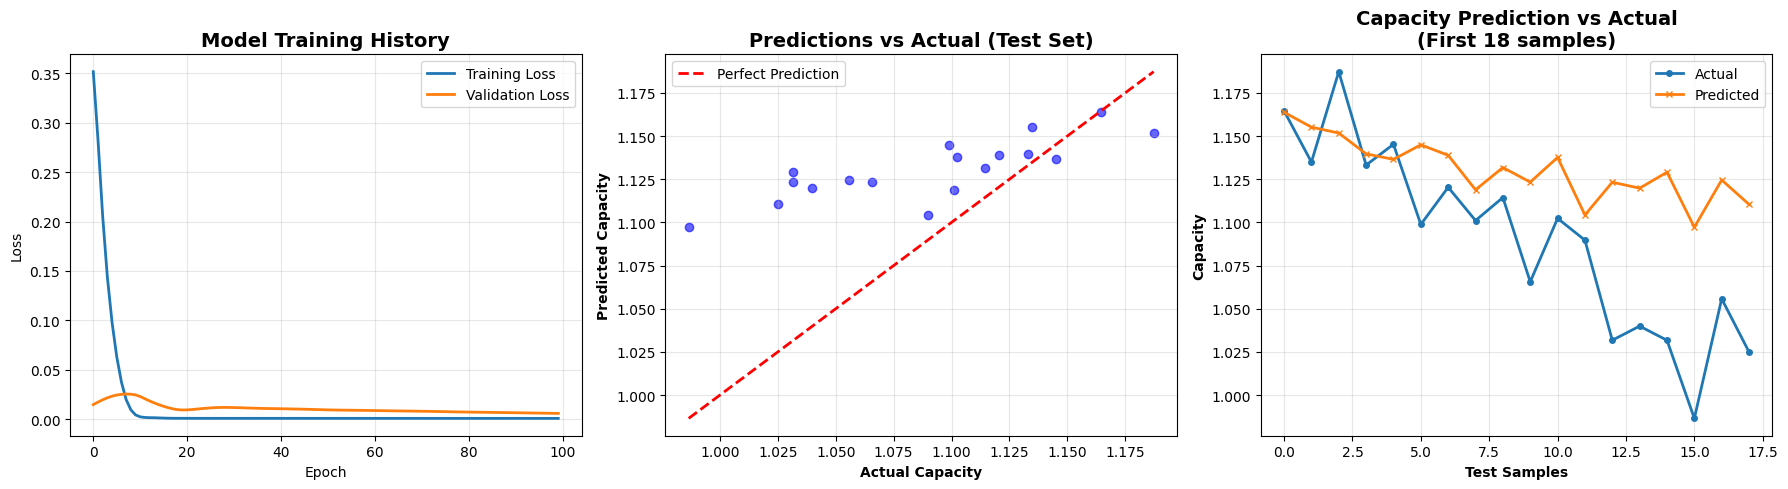

Visualizations created successfully!
Test set size: 18 samples
Plotted 18 samples in time series plot


In [27]:
# Create visualizations
plt.figure(figsize=(18, 5))

# Plot 1: Training history
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (Scatter)
plt.subplot(1, 3, 2)
plt.scatter(y_test_original, test_predictions, alpha=0.6, color='blue')
min_val = min(y_test_original.min(), test_predictions.min())
max_val = max(y_test_original.max(), test_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Capacity', fontweight='bold')
plt.ylabel('Predicted Capacity', fontweight='bold')
plt.title('Predictions vs Actual (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Time series prediction (FIXED - use actual available data points)
plt.subplot(1, 3, 3)
# Use the minimum available data points to avoid dimension mismatch
available_points = min(20, len(y_test_original), len(test_predictions))
sample_range = range(available_points)

plt.plot(sample_range, y_test_original[:available_points], label='Actual', marker='o', markersize=4, linewidth=2)
plt.plot(sample_range, test_predictions[:available_points], label='Predicted', marker='x', markersize=4, linewidth=2)
plt.xlabel('Test Samples', fontweight='bold')
plt.ylabel('Capacity', fontweight='bold')
plt.title(f'Capacity Prediction vs Actual\n(First {available_points} samples)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations created successfully!")
print(f"Test set size: {len(y_test_original)} samples")
print(f"Plotted {available_points} samples in time series plot")

In [28]:
# Save the trained model and scalers
dense_model.save('dense_battery_model.h5')
joblib.dump(scaler, 'capacity_scaler.pkl')
joblib.dump(y_scaler, 'target_scaler.pkl')

# Save results to DataFrame
results_df = pd.DataFrame({
    'actual': y_test_original,
    'predicted': test_predictions
})
results_df.to_csv('dense_model_predictions.csv', index=False)

print("Model and results saved!")
print("Files saved:")
print("  - dense_battery_model.h5 (trained model)")
print("  - capacity_scaler.pkl (input scaler)")
print("  - target_scaler.pkl (target scaler)")
print("  - dense_model_predictions.csv (predictions)")

print("\n DENSE MODEL COMPLETED SUCCESSFULLY!")
print("Ready for comparison with other models!")

Model and results saved!
Files saved:
  - dense_battery_model.h5 (trained model)
  - capacity_scaler.pkl (input scaler)
  - target_scaler.pkl (target scaler)
  - dense_model_predictions.csv (predictions)

 DENSE MODEL COMPLETED SUCCESSFULLY!
Ready for comparison with other models!
